In [ ]:
#|default_exp timm_sup

# Support for timm

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from types import SimpleNamespace

In [ ]:
# speed mods
from miniai.utils import *
from miniai.mixup import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [ ]:
rng = rng_seed

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds.cached = cache_dataset_as_dict(tds)

In [ ]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

# run

In [ ]:
dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics] 
#0.0003 from https://github.com/digantamisra9

In [ ]:
xb,yb = next(iter(dls.train))

In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

In [ ]:
from miniai.accel import AccelerateCB,MixedPrecision

In [ ]:
def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=TrainCB(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=False):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds.cached, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), rng_seed, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=optim.AdamW)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), ProgressCB(plot=True)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        if verbose: print('TTA:', round((ap==at).float().mean().item(), 4))
    
    return learn

In [ ]:
xb[0,0,0,0].item()


-0.800000011920929

# Resnet Upscaling 

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.840,0.463,0,train
0.912,0.246,0,eval


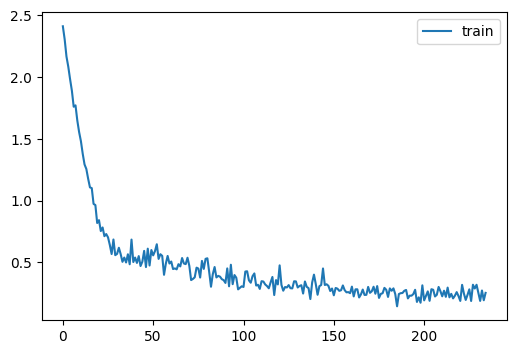

Fit 1 in: 20.75s, setup: 0.00s, 18.54 ± 0.00s per epoch, 0.03 ± 0.02s per batch


In [ ]:
rng.set_seed(1)
learn = run(
    timm_model('resnet18d', upscale32.nearest(2)), 
    leaky=0.0003, 
    base_lr=1e-2,
    epochs=1, 
    cbs=[], 
    train_cb=AccelerateCB(), 
    m=1)

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.841,0.453,0,train
0.912,0.242,0,eval


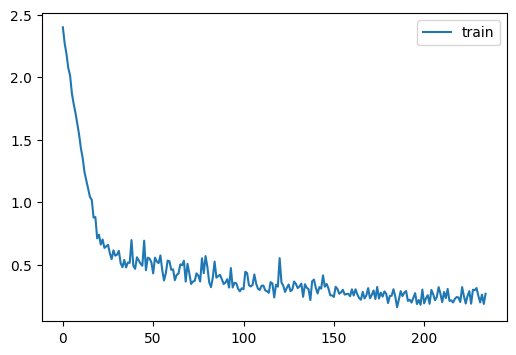

Fit 1 in: 23.40s, setup: 0.00s, 21.38 ± 0.00s per epoch, 0.05 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
learn = run(
    timm_model('resnet34d', upscale32.nearest(2)), 
    leaky=0.0003, 
    base_lr=1e-2,
    epochs=1, 
    cbs=[], 
    train_cb=MixedPrecision(), 
    m=1)

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.841,0.451,0,train
0.913,0.240,0,eval


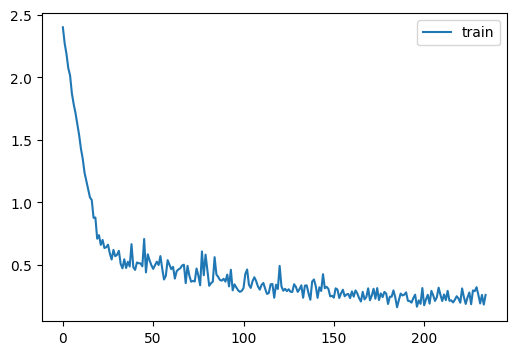

Fit 1 in: 27.98s, setup: 0.00s, 25.71 ± 0.00s per epoch, 0.06 ± 0.01s per batch


In [ ]:
rng.set_seed(1)
learn = run(
    timm_model('resnet34d', upscale32.nearest(2)), 
    leaky=0.0003, 
    base_lr=1e-2,
    epochs=1, 
    cbs=[], 
    #train_cb=MixedPrecision(), 
    m=1)